In [2]:
from PIL import Image
import requests
from io import BytesIO


def get_uptodate_pic():
    headers = {
        "authority": "buchung.hsz.rwth-aachen.de",
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-language": "en-US,en-DE;q=0.9,en;q=0.8,de-DE;q=0.7,de;q=0.6",
        "cache-control": "no-cache",
        "dnt": "1",
        "pragma": "no-cache",
        "referer": "https://buchung.hsz.rwth-aachen.de/angebote/aktueller_zeitraum/_Auslastung.html",
        "sec-ch-ua": '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Windows"',
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "same-origin",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    }
    
    params = {
        "size": "30",
    }
    
    r = requests.get(
        "https://buchung.hsz.rwth-aachen.de/cgi/studio.cgi", params=params, headers=headers
    )

    return Image.open(BytesIO(r.content))

In [104]:
auslastung = get_uptodate_pic()

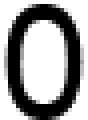

In [105]:
auslastung.resize((22 * 4, 30 * 4), resample=Image.NEAREST)

In [4]:
def split_img(img):
    parts = []
    for i in range(0, img.width, 22):
        #print(i)
        parts.append(img.crop((i, 0, i + 22 , img.height)).resize((22 * 4, 30 * 4), resample=Image.NEAREST).convert(mode="L"))
    return parts


In [95]:
import math

def make_diff(im1, im2):
    width, height = im1.size
    if im1.size != im2.size:
        print(im1.size, im2.size)
        raise ValueError("size mismatch")
    
    # Create a new blank image to store the difference
    diff_image = Image.new("L", (width, height))
    
    # Iterate over each pixel
    for x in range(width):
        for y in range(height):
            # Get the pixel values at (x, y) from both images
            pixel1 = im1.getpixel((x, y))
            pixel2 = im2.getpixel((x, y))
            
            # Calculate the difference between the pixel values
            
            # Set the difference pixel value in the new image
            diff_image.putpixel((x, y), 255 - abs(pixel2 - pixel1))
    
    # Display the difference image
    return diff_image

def diff_val(im1, im2):
    width, height = im1.size
    if im1.size != im2.size:
        print(im1.size, im2.size)
        raise ValueError("size mismatch")
    
    # Create a new blank image to store the difference
    val = 0
    
    # Iterate over each pixel
    for x in range(width):
        for y in range(height):
            # Get the pixel values at (x, y) from both images
            pixel1 = im1.getpixel((x, y))
            pixel2 = im2.getpixel((x, y))
            val += (pixel1 - pixel2) ** 2
    
    # Display the difference image
    return math.sqrt(val)

def match_number(toBeMatched, number_images):
    numbers_with_diff = zip(number_images.keys(), number_images.values(), [diff_val(im, toBeMatched) for im in number_images.values()])
    mind = min(numbers_with_diff, key=lambda item: item[2])
    return mind

In [107]:
def brute_force_font_params():
    from PIL import ImageDraw, ImageFont
    
    minVal = 99999999999
    minParam = None
    digit = split_img(auslastung)[0]
    for fsize in range(36, 42):
        font = ImageFont.truetype("arial.ttf", fsize)
        for x in range(-3, 3):
            for y in range(-15, 5):
                img = Image.new('L', (22, 30), color="white")
                d = ImageDraw.Draw(img)
                d.text((x, y), '0', fill=0, font=font)
                
                img = img.resize((22 * 4, 30 * 4), resample=Image.NEAREST)
                #img
                val = diff_val(digit, img)
                if val < minVal:
                    minVal = val
                    minParam = (fsize, x, y)
    
    print(minVal, minParam)

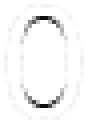

In [113]:
def make_synthetic_digit(character):
    img = Image.new('L', (22, 30), color="white")
    d = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 40)
    d.text((0, -7), character, fill=0, font=font)
    digit = split_img(auslastung)[0]
    img = img.resize((22 * 4, 30 * 4), resample=Image.NEAREST)
    return img
img = make_synthetic_digit("0")
make_diff(img, digit)

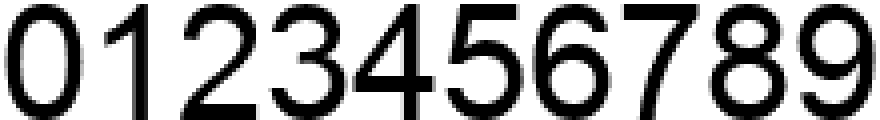

In [18]:
numbers = {}
for i in range(10):
    for k in pics.keys():
        ind = k.find(str(i))
        if ind == -1:
            continue
        numbers[i] = split_img(pics[k])[ind]
        break
    if not i in numbers:
        print("index {} not present".format(i))

def print_list_of_images(img_list):
    new_image = Image.new('RGB', (sum(img.width for img in img_list), max(img.height for img in img_list)), (255, 255, 255))
    
    # Paste each image into the new image
    x_offset = 0
    for img in img_list:
        new_image.paste(img, (x_offset, 0))
        x_offset += img.width
    
    # Display the new image
    display(new_image)
print_list_of_images(numbers.values())

In [26]:
auslastung

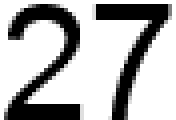

In [25]:
auslastung_digits = split_img(auslastung)

reconstructed_digits = []
for digit in auslastung_digits:
    reconstructed_digits.append(match_number(digit, numbers))

print_list_of_images([lol[1] for lol in reconstructed_digits])

In [27]:
''.join([str(digit[0]) for digit in reconstructed_digits])

'27'